### Import Libs

In [18]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.io
from scipy.ndimage import binary_dilation, generate_binary_structure
from scipy.optimize import curve_fit
from utils import plot_jungfrau, combineRuns, get_tree, is_leaf, get_leaves, runNumToString, enable_underscore_cleanup, keV2Angstroms
enable_underscore_cleanup() # Sets ipython hook to delete user defined varibles that start with _ at the end of each cell execution

In [19]:
# (1) keys_to_combine: some keys loaded for each shot & stored per shot 
# (2) keys_to_sum: some keys loaded per each run and added 
# (3) keys_to_check : check if some keys exits and have same values in all runs and load these keys 
keys_to_combine = [#'gas_detector/f_11_ENRC',
                   #'ebeam/photon_energy',
                   'evr/code_183',
                   'evr/code_137',
                   'evr/code_141',
                   'lightStatus/xray',
                   #'jungfrau4M/Full_thres_sum',
                   #'feeBld/hproj',
                   'lightStatus/laser',
                   'ipm_dg2/sum',
                    #'qadc0',
                   'evr/code_195',
                   'ipm_dg2/sum',
                    #'alvium_usr/usr_com',
                    #'alvium_usr/usr_sum',
                    #'alvium_usr/usr_pj0_data',
                    #'alvium_usr/usr_pj1_data',
                    'scan/lxt',
                    'alvium_u1/laser_downsample_data',
                    'alvium_u1/laser_sum',
                    #'tt/AMPL', 'tt/AMPLNXT', 'tt/FLTPOS', 'tt/FLTPOSFWHM', 'tt/FLTPOS_PS','tt/REFAMPL', 'tt/ttCorr',
                    #'ttRaw/tt_reference' , 'ttRaw/tt_reference_pj', 'ttRaw/tt_sideband', 'ttRaw/tt_sideband_pj', 'ttRaw/tt_signal', 'ttRaw/tt_signal_pj'
                  ]

keys_to_sum = [#'Sums/jungfrau4M_calib'
                ]
#               'Sums/jungfrau4M_calib_thresADU1']

keys_to_check = [
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_q',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_q',
                # 'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_idxq',
                # 'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_idxq',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbin',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbin',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_qbins',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_qbins',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_userMask',
                #'UserDataCfg/jungfrau4M/azav_mask1__azav_mask1_userMask',
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_q', # This are only needed once
                #'UserDataCfg/jungfrau4M/azav_mask0__azav_mask0_matrix_phi', # This are only needed once
                #'UserDataCfg/jungfrau4M/x',
                #'UserDataCfg/jungfrau4M/y',
                #'UserDataCfg/jungfrau4M/z',
                #'UserDataCfg/jungfrau4M/cmask'
                ]
#xray_energy = _data['gas_detector/f_11_ENRC']   # xray energy from gas detector (not calibrated to actual values)
#xray_eV = _data['ebeam/photon_energy']    # x-ray energy energy in eV|
#spec = _data['feeBld/hproj'] # Shot to shot spectrometer

# New data!
#aoptCam = _data['alvium_usr/usr_pj0_data'] # All optical phase tagging (AOPT alvium horizontal projection shot by shot)

In [20]:
###############################################
# 37 - 5.185 keV
runNumbers = [122]
folder = '/sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/'
#folder = '/sdf/data/lcls/ds/cxi/cxi100895124/scratch/davidjr/'
###############################################
_data = combineRuns(runNumbers, folder, keys_to_combine, keys_to_sum, keys_to_check, verbose=False)  # this is the function to load the data with defined keys

xrayOn= _data['evr/code_137'].astype(bool)  # Every hard xray shot
xrayOn2 = _data['lightStatus/xray'].astype(bool)  # evt code 137
laserOn = _data['lightStatus/laser'].astype(bool)  # not(evt code 184) (Duck shots)
gasOn = _data['evr/code_195'].astype(bool) # Gas on events

run_indicator = _data['run_indicator'] # run indicator for each shot
downsampledImg = _data['alvium_u1/laser_downsample_data']
u1Sum = _data['alvium_u1/laser_sum']
# ipm = _data['ipm_dg2/sum']
# ttAmpl = _data['tt/AMPL']
# ttAmplNXT = _data['tt/AMPLNXT']
# ttFltPos = _data['tt/FLTPOS']
# ttFWHM = _data['tt/FLTPOSFWHM']
# ttFltPosPs = _data['tt/FLTPOS_PS']
# ttREFAMPL = _data['tt/REFAMPL']
# ttCorr = _data['tt/ttCorr']

# ttRawRef = _data['ttRaw/tt_reference']
# ttRawRefPj = _data['ttRaw/tt_reference_pj']
# ttRawSb = _data['ttRaw/tt_sideband']
# ttRawSbPj = _data['ttRaw/tt_sideband_pj']
# ttRawSig = _data['ttRaw/tt_signal']
# ttRawSigPj = _data['ttRaw/tt_signal_pj']

scan = _data['scan/lxt']

photon_energy = 14.5  # keV

Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cxi100895124_Run0122.h5
Loaded Data


(array([7206., 3603., 3603., 3603., 3603., 3603., 3603., 3603., 3602.,
        5707.]),
 array([-2.00e-12, -1.89e-12, -1.78e-12, -1.67e-12, -1.56e-12, -1.45e-12,
        -1.34e-12, -1.23e-12, -1.12e-12, -1.01e-12, -9.00e-13]),
 <BarContainer object of 10 artists>)

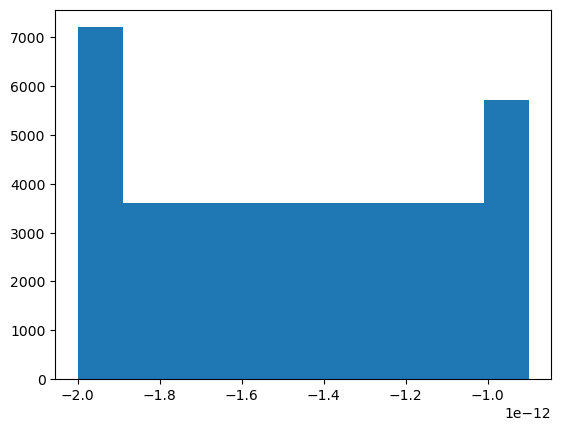

In [24]:
plt.hist(scan)

### Check the standard tt calaculations

NameError: name 'ttFltPos' is not defined

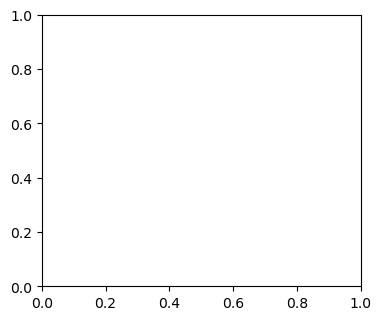

In [5]:
plt.figure(figsize=(14,12))
plt.subplot(3,3,1)
plt.hist(ttFltPos,bins=100)
plt.title('time-tool edge psoition')
plt.subplot(3,3,2)
plt.hist(ttAmpl,bins=100)
plt.title('time-tool amplitude')
plt.subplot(3,3,3)
plt.hist(ttFWHM,bins=100)
plt.title('time-tool fwhm')
plt.subplot(3,3,4)
plt.hist(ttCorr,bins=100)
plt.title('time-tool corr')
plt.subplot(3,3,5)
plt.hist(ttFltPosPs,bins=100)
plt.title('time-tool fltposps')
plt.subplot(3,3,6)
plt.hist(ttREFAMPL,bins=100)
plt.title('time-tool refampl')
plt.show()

In [ ]:
_ttBadIdx = ttFltPos<50
_ttGoodIdx = ttFltPos>800
for _j in range(0,2000):
    plt.plot(ttRawSigPj[_j],linewidth=0.8)

In [25]:
# Loading the cube data
_tdata = 'lxt' # Scan variable, LXT or lxttc
_vb = True # Verbose
data_on = {}
filename = f'{folder}cube/Cube_cxi100895124_Run{runNumToString(runNumbers[0])}_{_tdata}_on.h5'
print('Loading: ' + filename)
with h5py.File(filename,'r') as f:
    get_leaves(f,data_on,verbose=_vb)
data_off = {}
filename = f'{folder}cube/Cube_cxi100895124_Run{runNumToString(runNumbers[0])}_{_tdata}_off.h5'
print('Loading: ' + filename)
with h5py.File(filename,'r') as f:
    get_leaves(f,data_off,verbose=_vb)
data_bkgon = {}
filename = f'{folder}cube/Cube_cxi100895124_Run{runNumToString(runNumbers[0])}_{_tdata}_background_on.h5'
print('Loading: ' + filename)
with h5py.File(filename,'r') as f:
    get_leaves(f,data_bkgon,verbose=_vb)
data_bkgoff = {}
filename = f'{folder}cube/Cube_cxi100895124_Run{runNumToString(runNumbers[0])}_{_tdata}_background_off.h5'
print('Loading: ' + filename)
with h5py.File(filename,'r') as f:
    get_leaves(f,data_bkgoff,verbose=_vb)

Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cube/Cube_cxi100895124_Run0122_lxt_on.h5
alvium_u1_data (13, 1000, 1000)
alvium_u1_nEntries (13,)
binVar (13,)
binVar_bins (13,)
cubeSelection (1,)
delay (13,)
ipm_dg2__sum (13,)
lightStatus__xray (13,)
nEntries (13,)
Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cube/Cube_cxi100895124_Run0122_lxt_off.h5
alvium_u1_data (13, 1000, 1000)
alvium_u1_nEntries (13,)
binVar (13,)
binVar_bins (13,)
cubeSelection (1,)
delay (13,)
ipm_dg2__sum (13,)
lightStatus__xray (13,)
nEntries (13,)
Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cube/Cube_cxi100895124_Run0122_lxt_background_on.h5
alvium_u1_data (13, 1000, 1000)
alvium_u1_nEntries (13,)
binVar (13,)
binVar_bins (13,)
cubeSelection (1,)
delay (13,)
ipm_dg2__sum (13,)
lightStatus__xray (13,)
nEntries (13,)
Loading: /sdf/data/lcls/ds/cxi/cxi100895124/hdf5/smalldata/cube/Cube_cxi100895124_Run0122_lxt_background_off.h5
alvium_u1_data (13, 1000, 1000)
alvium_u1_nEn

In [26]:
print(data_bkgoff['binVar_bins'])

[-2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9]


### Plotting the average images from each cube

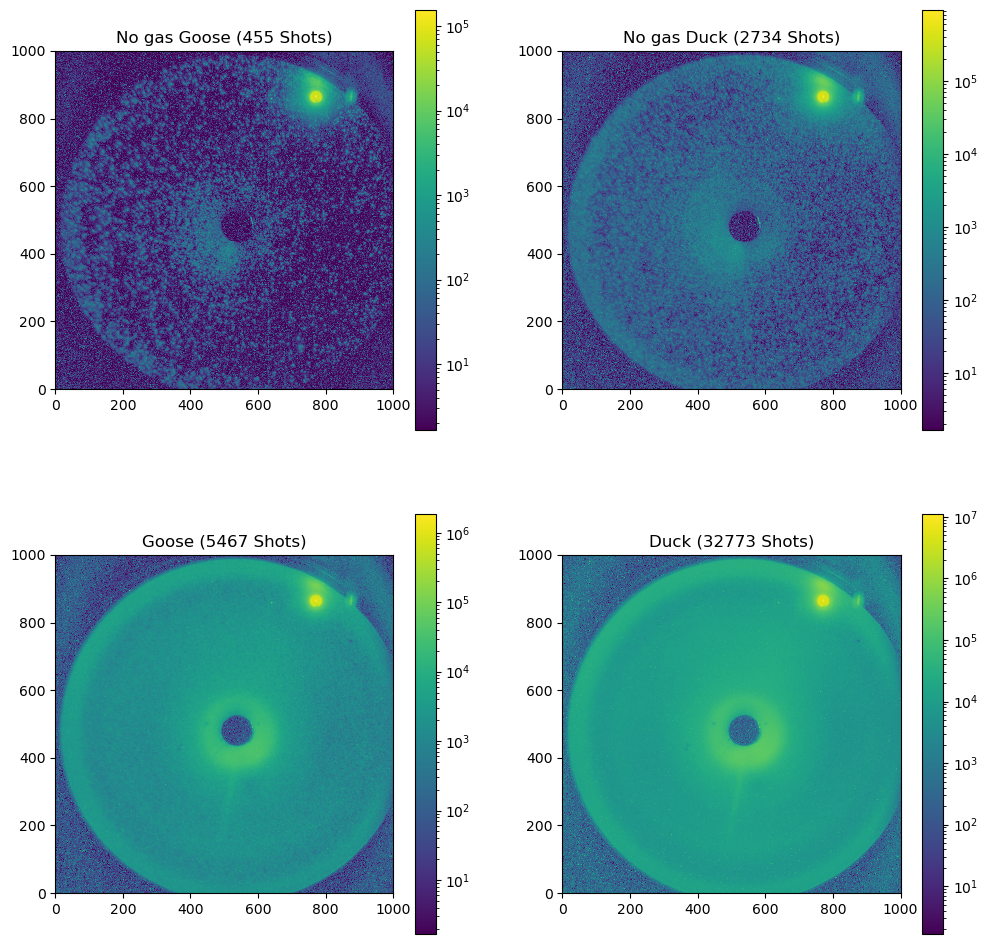

In [27]:
plt.figure(figsize=[12,12])

bkgoffSum = np.nanmean(data_bkgoff['alvium_u1_data'],axis=0)
bkgonSum = np.nanmean(data_bkgon['alvium_u1_data'],axis=0)
offSum = np.nanmean(data_off['alvium_u1_data'],axis=0)
onSum = np.nanmean(data_on['alvium_u1_data'],axis=0)
plt.subplot(2,2,1)
plt.pcolor(bkgoffSum,norm=LogNorm())
plt.colorbar()
plt.axis('image')
plt.title('No gas Goose ({:.0f} Shots)'.format(np.nansum(data_bkgoff['nEntries'])))
plt.subplot(2,2,2)
plt.pcolor(bkgonSum,norm=LogNorm())
plt.colorbar()
plt.axis('image')
plt.title('No gas Duck ({:.0f} Shots)'.format(np.nansum(data_bkgon['nEntries'])))
plt.subplot(2,2,3)
plt.pcolor(offSum,norm=LogNorm())
plt.colorbar()
plt.axis('image')
plt.title('Goose ({:.0f} Shots)'.format(np.nansum(data_off['nEntries'])))
plt.subplot(2,2,4)
plt.pcolor(onSum,norm=LogNorm())
plt.colorbar()
plt.axis('image')
plt.title('Duck ({:.0f} Shots)'.format(np.nansum(data_on['nEntries'])))
plt.show()

### Combining the backgrounds for a subtraction

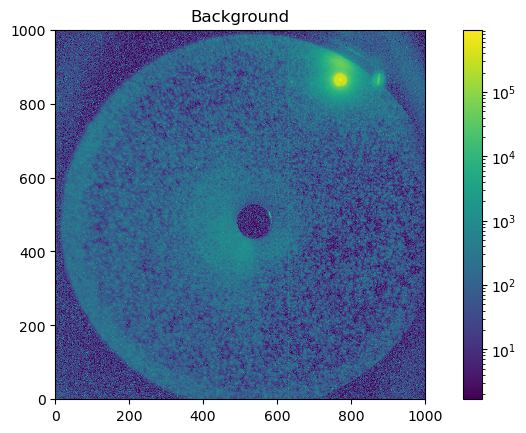

In [28]:
bkg = bkgonSum
plt.pcolor(bkg,norm=LogNorm())
plt.colorbar()
plt.axis('image')
plt.title('Background')
plt.show()

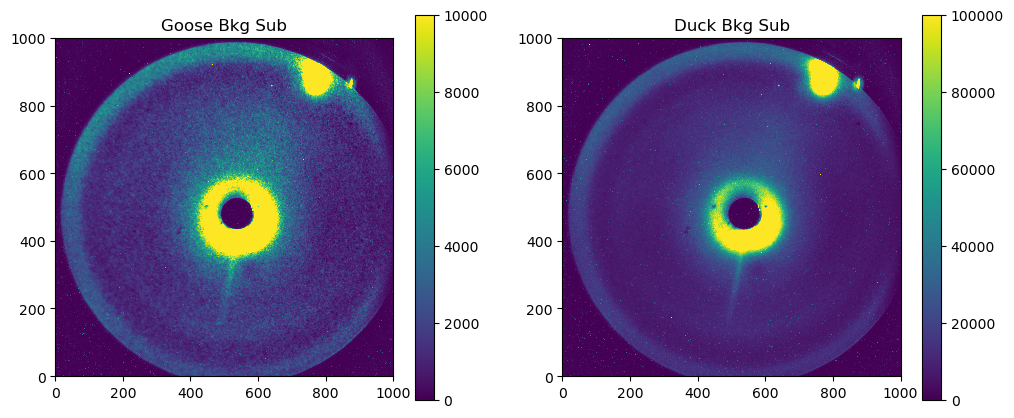

In [29]:
cube_bkgoff = data_bkgoff['alvium_u1_data']-bkg
cube_bkgon = data_bkgon['alvium_u1_data']-bkg
cube_off = data_off['alvium_u1_data']-bkg
cube_on = data_on['alvium_u1_data']-bkg

plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
plt.pcolor(np.nanmean(cube_off,axis=0))
plt.colorbar()
plt.clim([0,1e4])
plt.axis('image')
plt.title('Goose Bkg Sub')
plt.subplot(1,2,2)
plt.pcolor(np.nanmean(cube_on,axis=0))
plt.colorbar()
plt.clim([0,1e5])
plt.axis('image')
plt.title('Duck Bkg Sub')
plt.show()

In [ ]:
_subCubeOff = np.nanmean(cube_off,axis=0)
_subCubeOff[780:1000,640:900] = 0
_subCubeOn = np.nanmean(cube_on,axis=0)
_subCubeOn[780:1000,640:900] = 0
subCubeOff = _subCubeOff/np.sum(_subCubeOff)
subCubeOn = _subCubeOn/np.sum(_subCubeOn)
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.pcolor(subCubeOff)
plt.colorbar()
plt.clim([0,0.5e-5])
plt.axis('image')
plt.title('Goose Bkg Sub')
plt.subplot(1,2,2)
plt.pcolor(subCubeOn)
plt.colorbar()
plt.clim([0,0.2e-5])
plt.axis('image')
plt.title('Duck Bkg Sub')
plt.show()

In [ ]:
plt.pcolor(subCubeOn-subCubeOff,cmap='bwr')
plt.colorbar()
plt.axis('image')
plt.clim([-1e-6,1e-6])

In [ ]:
def downsample_mean2(arr, factor):
    """
    Downsamples a 2D NumPy array by taking the mean over non-overlapping blocks.

    Parameters:
    - arr: 2D NumPy array (e.g., shape (1000, 1000))
    - factor: int, downsampling factor along each axis (e.g., 4 for 1000→250)

    Returns:
    - downsampled: 2D NumPy array of shape (original_shape // factor)
    """
    assert arr.shape[0] % factor == 0 and arr.shape[1] % factor == 0, "Array dimensions must be divisible by factor"
    reshaped = arr.reshape(arr.shape[0]//factor, factor, arr.shape[1]//factor, factor)
    downsampled = reshaped.mean(axis=(1, 3))
    return downsampled

# ds_factor = 10
# alvium_u1_data_on_ds = downsample_mean(alvium_u1_data_on, ds_factor)
# alvium_u1_data_off_ds = downsample_mean(alvium_u1_data_off, ds_factor)
# alvium_u1_data_bkgon_ds = downsample_mean(alvium_u1_data_bkgon, ds_factor)
# alvium_u1_data_bkgoff_ds = downsample_mean(alvium_u1_data_bkgoff, ds_factor)

# x_ds,y_ds = np.arange(0,1000,ds_factor),np.arange(0,1000,ds_factor)
# XX,YY = np.meshgrid(x_ds,y_ds)

In [ ]:
nplts = len(data_on['binVar_bins'])
plt.figure(figsize=[12,12])
for nbin in range(1,nplts):
    #print(nbin)
    cube_on[nbin][780:1000,640:900] = 0
    cube_off[nbin][780:1000,640:900] = 0
    _cube_on = cube_on[nbin]/cube_on[nbin].sum()
    _cube_off = cube_off[nbin]/cube_off[nbin].sum()
    _pltvar = downsample_mean2(_cube_on-_cube_off,10)
    plt.subplot(6,5,nbin)
    plt.pcolor(_pltvar,cmap='bwr',vmax=_pltvar.max(),vmin=-_pltvar.max())
    plt.title(data_on['binVar_bins'][nbin])
    plt.colorbar()
    plt.axis('image')